# Reconocimento de imágenes de perros perdidos mediante Transfer Learning con MobileNetV2: Dog Finder

El presente notebook muestra cómo funciona el sistema  de reconocimiento de imágenes de perros perdidos utilizando Transfer Learning con MobileNetV2 y una base de datos SQLite.


## Resumen del Flujo del Programa

1. **Preparación de entorno y bibliotecas**: Se importan todas las bibliotecas necesarias.
2. **Implementación del modelo como Extractor de Caracteristicas:  ```DogRecognitionModel```**: Se define la clase para extraer características de las imágenes usando MobileNetV2.
     * Congelamiento de capas entrenadas
     * Congelamiento de la capa de clasificación
     * Creación de un vector de características
     * Cargar pesos entrenados de Imagenet
* **Preprocesamiento de imágenes**
     * Cargar la imagen
     * Convertir BGR a RGB
     * Redimensionar la imagen a 224x224 píxeles
     * Convertir a float32 para procesamiento
     * Expandir dimensiones
     * Preprocesamiento específico de MobileNetV2
3. **Implementación de la base de datos**: Se define la estructura de la base de datos SQLite con SQLAlchemy
4. **Registro automático de imágenes**: Se procesan y registran las imágenes de un directorio en la base de datos.
5. **Definir ```show_image```**: Se define la función para mostrar las imágenes.
6. **Implementación de la búsqueda por similitud: ```search_similar_dogs```**: Se define la función para buscar perros similares en la base de datos.
7. **Realizar Búsqueda de Prueba**: Se realiza una búsqueda de prueba para demostrar cómo funciona el sistema.


## 1. Configuración incial

Clonar el repositorio completo en Colab

In [56]:
# Borra el repositorio si ya existe, para evitar errores al clonar
!rm -rf TFG-DogFinder
!git clone https://github.com/dasniela/TFG-DogFinder.git
import os
os.chdir('TFG-DogFinder')
print("Directorio actual:", os.getcwd())
print("Contenido:", os.listdir('.'))


Cloning into 'TFG-DogFinder'...
remote: Enumerating objects: 14133, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 14133 (delta 1), reused 0 (delta 0), pack-reused 14127 (from 1)
Receiving objects: 100% (14133/14133), 669.97 MiB | 34.95 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (14155/14155), done.
Directorio actual: /content/TFG-DogFinder/TFG-DogFinder/TFG-DogFinder/TFG-DogFinder
Contenido: ['Stanford_images', 'TFG-DogFinder.ipynb', 'test_images', '.gitignore', '.git', 'README.md']


Instalar las dependencias necesarias

In [57]:
pip install tensorflow opencv-python sqlalchemy matplotlib

## 2. Preparación de entorno y bibliotecas:

- ```os```: Para interactuar con el sistema operativo (por ejemplo, para trabajar con rutas de archivos).
- ```numpy (np)```: Para operaciones numéricas eficientes, especialmente con arreglos.
- ```tensorflow (tf)```: La biblioteca principal para construir y entrenar modelos de aprendizaje profundo.
- ```cv2 (OpenCV)```: Para procesamiento de imágenes (leer, escribir, manipular).
- ```tensorflow.keras.applications.MobileNetV2```: Un modelo de red neuronal pre-entrenado para la extracción de características de imágenes.
- ```tensorflow.keras.applications.mobilenet_v2.preprocess_input```: Función para preprocesar imágenes para MobileNetV2.
- ```tensorflow.keras.models.Model```: Para definir modelos en TensorFlow/Keras.
- ```sqlalchemy```: Una biblioteca para interactuar con bases de datos relacionales (en este caso, SQLite).
- ```datetime```: Para trabajar con fechas y horas.
- ```json```: Para trabajar con datos en formato JSON (usado para almacenar características de imágenes).
- ```matplotlib.pyplot (plt)```: Para visualizar imágenes y otros gráficos.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sqlalchemy import create_engine, Column, Integer, String, DateTime
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker
from datetime import datetime
import json
import matplotlib.pyplot as plt

## Implementación del modelo como Extractor de Características

La clase DogRecognitionModel
- Implementa de manera competente una pipeline para la extracción de características de imágenes utilizando la arquitectura eficiente MobileNetV2 y la técnica de aprendizaje por transferencia
- Carga un modelo pre-entrenado en ImageNet, lo adapta para la extracción de características congelando sus pesos y eliminando la capa de clasificación
- Aplica preprocesamiento estándar de imágenes (carga, conversión de color, redimensionamiento) y normalización específica del modelo
- Genera un vector de características L2 normalizado de 1280 dimensiones para cada imagen de entrada.

In [ ]:
class DogRecognitionModel:

    #INICIALIZACIÓN DEL MODELO
    def __init__(self):
        base_model = MobileNetV2(
            input_shape=(224, 224, 3),  # Tamaño estándar para MobileNetV2 (alto, ancho, canales)
            include_top=False,          # CONGELAMIENTO DE CAPA DE CLASIFICACIÓN: se desactiva la capa de clasificación
            pooling='avg',              # CREACUÓN DE UN VECTOR DE CARACTERISTICAS: Pooling promedio global para obtener vector de características
            weights='imagenet'          # CARGAR PESOS PREENTRENADOS DE IMAGENET
        )

        # CONGELAMIENTO DE CAPAS PREENTRENADAS: Se congela los pesos para usar solo como extractor
        base_model.trainable = False

        # Definir el modelo extractor
        self.feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    #PREPROCESAMIENTO DE IMAGENES
    def preprocess_image(self, image_path):
        # 1. Cargar imagen con OpenCV
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f'No se pudo cargar la imagen: {image_path}')

        # 2. Convertir de BGR a RGB (OpenCV usa BGR por defecto, modelos entrenados con ImageNet requieren RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 3. Redimensionar a 224x224 (tamaño requerido por MobileNetV2)
        img = cv2.resize(img, (224, 224))

        # 4. Convertir a float32 para procesamiento
        img = img.astype('float32')

        # 5. Expandir dimensiones para lote (modelo espera lote aún si solo será una imagen)
        img = np.expand_dims(img, axis=0)

        # 6. Preprocesar para MobileNetV2 (normaliza a [-1,1])
        return preprocess_input(img)

    def extract_features(self, image):
        # 1. Extraer características usando el modelo.
        # verbose controla la verbosidad durante la predicción. (el valor 0 significa modo silencioso, sin mostrar ninguna salida de progreso).
        features = self.feature_extractor.predict(image, verbose=0)

        # 2. Normalizar el vector (importante para comparación coseno)
        # Dividimos por la norma para obtener un vector unitario
        features = features / np.linalg.norm(features)

        return features

    def process_image(self, image_path):
        # Método que combina preprocesamiento y extracción
        img = self.preprocess_image(image_path)
        return self.extract_features(img)

## Implementación de la Base de Datos

### Diseño de la Base de Datos
Utilizamos SQLite con SQLAlchemy como ORM. Se definió una única tabla llamada ```dogs```, la cual almacena la infromación relevante de cada perro registrado en el sistema

```dogs```:
* **id:** Identificador único para cada registro
* **name:** Nombre del perro o del archivo
* **location**: Ubicación donde fue encontrado el perro
* **found_date**: Fecha y hora en que se registro el perro perdido
* **image_path**: Ruta local de la imagen asociada al perro
* **features**: Vector de características extraídas de la imagen, almacenado como cade en formato JSON


### Configuración de la base de datos con SQLAlchemy

In [ ]:
# Se crea una clase base declarativa, de ella heredan todas las clases que representen tablas en la base de datos
Base = declarative_base()

# Se define una clase llamada Dog que hereda de Base, que representa un modelo para una tabla de la base de datos.
class Dog(Base):
    # Se especifica que esta clase se mapeará a una tabla llamada dogs en la base de datos.
    __tablename__ = 'dogs'

    id = Column(Integer, primary_key=True)            # Identificador único para cada registro
    name = Column(String(100), nullable=True)         # Nombre del perro o del archivo (opcional)
    location = Column(String(500), nullable=False)    # Ubicación donde fue encontrado el perro
    found_date = Column(DateTime, nullable=False)     # Ubicación donde fue encontrado el perro
    image_path = Column(String(1000), nullable=False) # Ubicación donde fue encontrado el perro
    features = Column(String, nullable=False)         # Vector de características en JSON

# CREAR BASE DE DATOS

# El prefijo sqlite:/// indica que se está utilizando una base de datos SQLite y se se creará un archivo llamado dog_finder_demo_v3.db
db_path = 'sqlite:///dog_finder_demo_v3.db'
engine = create_engine(db_path)  #Se crea un "motor" de SQLAlchemy que funciona como la interfaz principal para la base de datos y maneja la conexión.
Base.metadata.create_all(engine)  # Este comando crea la tabla dogs en la base de datos especificada por el engine, si aún no existen.

# CREAR UNA SESIÓN PARA INTERACTIAR CON LA BD

#Se crea una fábrica de sesiones. Una sesión de SQLAlchemy proporciona una forma de interactuar con la base de datos. Se vincula la fábrica de sesiones al engine de la base de datos.
Session = sessionmaker(bind=engine)
session = Session() #Se crea una instancia de la sesión por medio de la cual se realizarán todas las operaciones en la base de datos.


### Registro automático de imagenes en la base de datos

Con el fin de facilitar la carga de datos, se implementó un método de registro automático que permite escanear de manera masiva una carpeta con imágenes llamada test_images y almacenar sus características en la base de datos.

La función ```is_duplicate_image``` verifica si una imagen ya existe en la base de datos en cuyo caso devolvera true, esto con el fin del evitar duplicados. Los argumentos que recibe son:

* new_features: El vector de características de la nueva imagen.
* threshold: El umbral de similitud para considerar una imagen como duplicada.



In [ ]:
# Inicializar modelo de reconocimiento
model = DogRecognitionModel()

#FUNCION PARA EVITAR ALMACENAR EN LA BD IMAGENES DUPLICADAS
def is_duplicate_image(new_features, threshold=0.999):  # Umbral alto para detectar imagenes iguales
    for dog in session.query(Dog).all():
        db_features = np.array(json.loads(dog.features))
        similarity = float(np.dot(new_features.flatten(), db_features.flatten()))
        if similarity > threshold:
            return True
    return False


test_images_dir = 'test_images'  # se define la ruta al directorio test_images
#test_images_dir = 'Stanford_images'  # se define la ruta al directorio Stanford_images
if os.path.exists(test_images_dir):  # Se verifica si el directorio existe.
    print(f'Registrando imágenes de {test_images_dir}...')
    count = 0
    for fname in os.listdir(test_images_dir):  # Se itera sobre todos los archivos y directorios dentro del directorio test_images_dir
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Se verifica si el nombre del archivo termina con las extensiones de imagen compatibles (.jpg, .jpeg, .png), ignorando las mayúsculas.
            img_path = os.path.join(test_images_dir, fname)  # Se construye la ruta completa al archivo de la imagen.

            try:  # Manejo de excepcion con try-except
                # Se utiliza el modelo DogRecognitionModel para extraer características devolviendo un vector de características
                features = model.process_image(img_path)

                # VERIFICAR QUE LA IMAGEN NO ES DUPLICADA
                if not is_duplicate_image(features):
                    # El vector de características (array de NumPy) se convierte primero a una lista y luego a una cadena JSON para poder almacenarlo en la columna features de la BD.
                    features_json = json.dumps(features.tolist())

                    # CREAR REGISTRO EN LA BD
                    dog = Dog(
                        name=fname,  # Usamos nombre de archivo
                        location='Desconocida',
                        found_date=datetime.now(),
                        image_path=img_path,
                        features=features_json
                    )

                    # ALMACENAR EN LA BD
                    session.add(dog)  # Se agrega el nuevo objeto Dog a la sesión de SQLAlchemy, lo que lo marca para ser insertado en la base de datos.
                    session.commit()  # Se confirman los cambios pendientes en la sesión y se escriben en la base de datos.
                    count += 1  # Se incrementa un contador de imágenes registradas.
                    print(f'Registrada imagen: {fname}')
                else:
                    print(f'Imagen {fname} es un duplicado, no se agregó.')

            except Exception as e:
                print(f'Error con {fname}: {e}')

else:
    print(f'¡Advertencia! No se encontró el directorio {test_images_dir}')


Registrando imágenes de test_images...
Imagen panchita7.JPG es un duplicado, no se agregó.
Imagen ale.JPG es un duplicado, no se agregó.
Imagen lummi3.JPG es un duplicado, no se agregó.
Imagen benito2.JPG es un duplicado, no se agregó.
Imagen bulldog6.JPG es un duplicado, no se agregó.
Imagen pipa2.JPG es un duplicado, no se agregó.
Imagen osita1.jpg es un duplicado, no se agregó.
Imagen frenchi1.JPG es un duplicado, no se agregó.
Imagen lucy9.JPG es un duplicado, no se agregó.
Imagen frenchi4.JPG es un duplicado, no se agregó.
Imagen beagle1.jpeg es un duplicado, no se agregó.
Imagen dember4.jpg es un duplicado, no se agregó.
Imagen matilda6.JPG es un duplicado, no se agregó.
Imagen nita2.JPG es un duplicado, no se agregó.
Imagen lummi4.JPG es un duplicado, no se agregó.
Imagen corgi1.jpg es un duplicado, no se agregó.
Imagen lucy6.png es un duplicado, no se agregó.
Imagen javo.jpeg es un duplicado, no se agregó.
Imagen lilith3.jpg es un duplicado, no se agregó.
Imagen kito5.JPG es un

In [ ]:
# Mostrar el total de imágenes en la base de datos
total_images = session.query(Dog).count()
print(f"\nTotal de imágenes en la base de datos: {total_images}")


Total de imágenes en la base de datos: 312


### Resetear BD cuando ejecutas muchas veces el codigo anterior

In [ ]:
def reset_database():
    """Borra todos los registros de la tabla 'dogs'."""
    session.query(Dog).delete()
    session.commit()
    print("Base de datos reiniciada.")

reset_database()

## 4. Pruebas de Búsqueda

Ahora vamos a probar el sistema buscando perros similares a una imagen de prueba.
El proceso es el siguiente:
1. Seleccionamos una imagen de prueba
2. Extraemos sus características
3. Comparamos con todas las imágenes en la base de datos
4. Mostramos los resultados ordenados por similitud

### Función para mostrar imágen
La función show_image toma la ruta de una imagen, la carga, la convierte al formato de color correcto, la muestra en una ventana y, opcionalmente, le agrega un título. Es una función de utilidad que simplifica la visualización de imágenes en el programa.

In [ ]:
# Función para mostrar imágenes
def show_image(image_path, title=None): #Define una función llamada show_image que toma la ruta de una imagen (image_path) y un título opcional (title) como argumentos.


    #Utiliza la función imread de la librería cv2 (OpenCV) para leer la imagen desde la ruta especificada y la almacena en la variable img.
    # OpenCV lee las imágenes en formato BGR (Azul, Verde, Rojo).
    img = cv2.imread(image_path)
    if img is None:  #Verifica si la imagen se cargó correctamente.
        print(f'No se pudo cargar la imagen: {image_path}')
        return

    # Convierte el espacio de color de la imagen de BGR a RGB (Rojo, Verde, Azul).
    # Matplotlib, que se utilizará para mostrar la imagen, espera las imágenes en formato RGB.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6 )) # Crea una nueva figura para la gráfica con un tamaño específico (ancho de 8 pulgadas y alto de 6 pulgadas).
    plt.imshow(img) # Muestra la imagen utilizando la función imshow de Matplotlib.
    if title: #verifica si se proporcionó un título.
        plt.title(title) #se establece el título de la gráfica utilizando plt.title(title).
    plt.axis('off') #  Desactiva la visualización de los ejes (las marcas y los números en los bordes de la imagen).
    plt.show() # Muestra la figura con la imagen.

### Funcion para buscar perros similares
Define una función llamada search_similar_dogs que toma un vector de características (features) de la imagen de consulta y un umbral de similitud (threshold) como argumentos.

In [ ]:
def search_similar_dogs(features, threshold=0.5):

    results = [] # Inicializa una lista vacía para almacenar los resultados de la búsqueda.

    # Consultar todos los perros en la base de datos
    # Realiza una consulta a la base de datos utilizando la sesión de SQLAlchemy para obtener todos los registros de la tabla Dog.
    # Itera sobre cada perro encontrado en la base de datos.
    for dog in session.query(Dog).all():
        # Convertir características de JSON a numpy array
        db_features = np.array(json.loads(dog.features))

        # Calcular similitud coseno (producto punto de vectores normalizados)
        """Calcula la similitud entre el vector de características de la imagen de búsqueda (features) y el vector de características
        del perro en la base de datos (db_features). Aquí se está utilizando el producto punto de los vectores aplanados como
        una medida de similitud. En el contexto de vectores normalizados (que se asume que son las características extraídas por el modelo),
        el producto punto es equivalente a la similitud coseno. Un valor más alto indica una mayor similitud.
        """

        # Normalizar el vector de características de la base de datos
        similarity = float(np.dot(features.flatten(), db_features.flatten()))

        # Agregar a resultados si supera el umbral
        if similarity > threshold:

            results.append({ #Si la similitud supera el umbral, se crea un diccionario con la información relevante del perro encontrado y se agrega a la lista results.
                'id': dog.id,
                'similarity': similarity,
                'name': dog.name,
                'location': dog.location,
                'found_date': dog.found_date,
                'image_path': dog.image_path
            })

    # Ordenar por similitud (mayor primero)
    #Después de iterar sobre todos los perros en la base de datos, la función ordena la lista results en función de la similitud ('similarity')
    # en orden descendente (reverse=True), de modo que los perros más similares aparecen primero.
    return sorted(results, key=lambda x: x['similarity'], reverse=True)

### Busqueda de prueba
Esta sección demuestra cómo usar las funciones definidas anteriormente para realizar una búsqueda de perros similares.

Imagen de búsqueda:


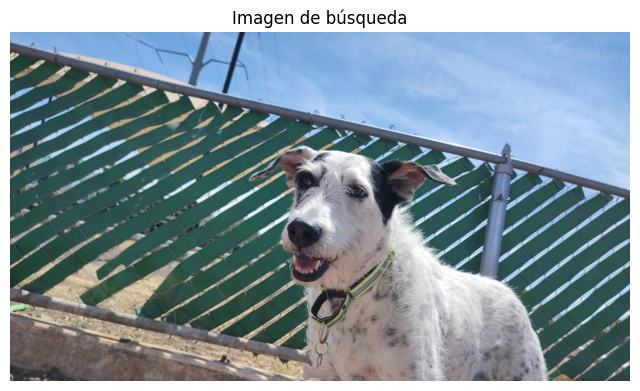

Extrayendo características...
Buscando perros similares...

Resultados de la búsqueda: 31 coincidencias encontradas

Coincidencia #1
ID: 196
Similitud: 100.00%
Nombre: Lummi2.jpeg
Ubicación: Desconocida
Fecha: 2025-05-27 03:06:52.237777


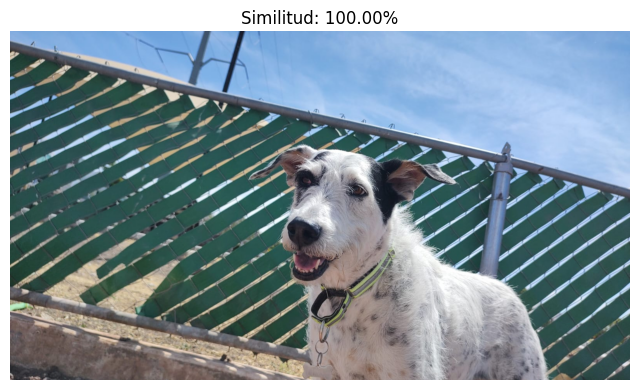


Coincidencia #2
ID: 167
Similitud: 66.13%
Nombre: Lummi1.jpeg
Ubicación: Desconocida
Fecha: 2025-05-27 03:06:42.721278


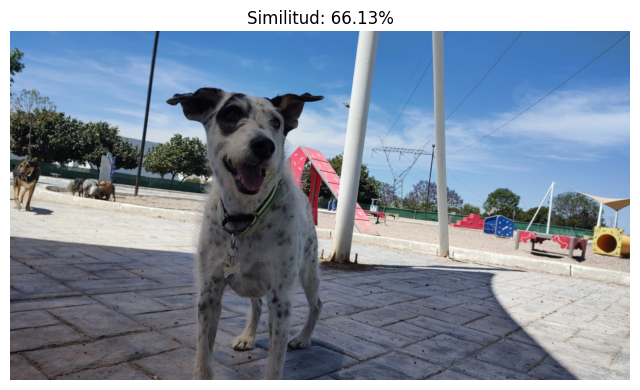


Coincidencia #3
ID: 65
Similitud: 63.60%
Nombre: Lummi15.JPEG
Ubicación: Desconocida
Fecha: 2025-05-27 03:06:16.151888


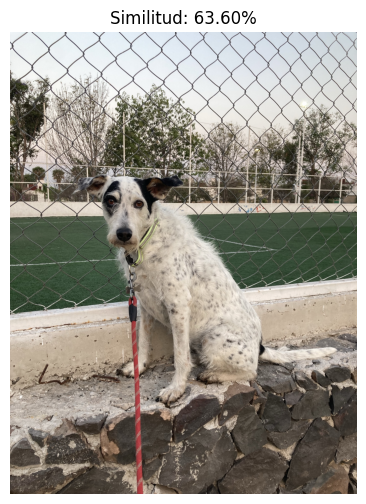


Coincidencia #4
ID: 15
Similitud: 62.10%
Nombre: lummi4.JPG
Ubicación: Desconocida
Fecha: 2025-05-27 03:06:05.333055


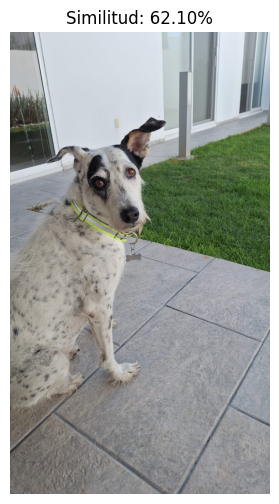


Coincidencia #5
ID: 185
Similitud: 62.05%
Nombre: lummi6.jpg
Ubicación: Desconocida
Fecha: 2025-05-27 03:06:48.880746


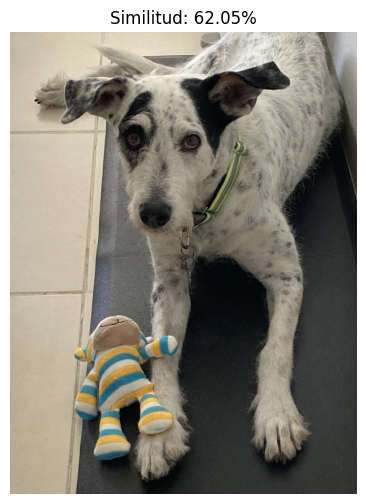

In [ ]:
# Puedes cambiar esta imagen por cualquier otra que quieras probar
search_image = 'test_images/Lummi2.jpeg'
#search_image = 'Stanford_images/panchita2.jpg'

if os.path.exists(search_image):  #Se verifica si la imagen de búsqueda existe.
    # Mostrar la imagen de búsqueda
    print('Imagen de búsqueda:')
    show_image(search_image, 'Imagen de búsqueda')

    # Extraer características
    print('Extrayendo características...')
    features = model.process_image(search_image) #Se utiliza el modelo de reconocimiento (model) para extraer las características de la imagen de búsqueda.


    # Buscar similares
    print('Buscando perros similares...')
    #Se llama a la función search_similar_dogs con las características extraídas y un umbral de similitud de 0.5 para encontrar perros similares en la base de datos.
    results = search_similar_dogs(features, threshold=0.5)

    # Mostrar resultados
    print(f'\nResultados de la búsqueda: {len(results)} coincidencias encontradas')

    # Mostrar los 5 mejores resultados
    for i, result in enumerate(results[:5]):
        print(f"\nCoincidencia #{i+1}")
        print(f"ID: {result['id']}")
        print(f"Similitud: {result['similarity']:.2%}")
        print(f"Nombre: {result['name']}")
        print(f"Ubicación: {result['location']}")
        print(f"Fecha: {result['found_date']}")

        # Mostrar la imagen encontrada
        #Se muestra la imagen del perro encontrado en la base de datos junto con su puntuación de similitud como título.
        show_image(result['image_path'], f"Similitud: {result['similarity']:.2%}")
else:
    print(f'No se encontró la imagen de búsqueda: {search_image}')